In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
import numpy as np
import pandas as pd
import json
import os
from cassandra.cluster import Cluster
from cassandra import util
from sklearn import linear_model
from luminol import anomaly_detector
from stldecompose import decompose


Populating the interactive namespace from numpy and matplotlib


/home/nico/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cluster = Cluster()
session = cluster.connect('db_tsa')

rows = session.execute("SELECT name, dateof(event_time) AS event_time FROM time_series where name='movi' ORDER BY event_time ASC")
seriesdates = [item[1] for item in rows]
main_ts = pd.Series(1, index = seriesdates)

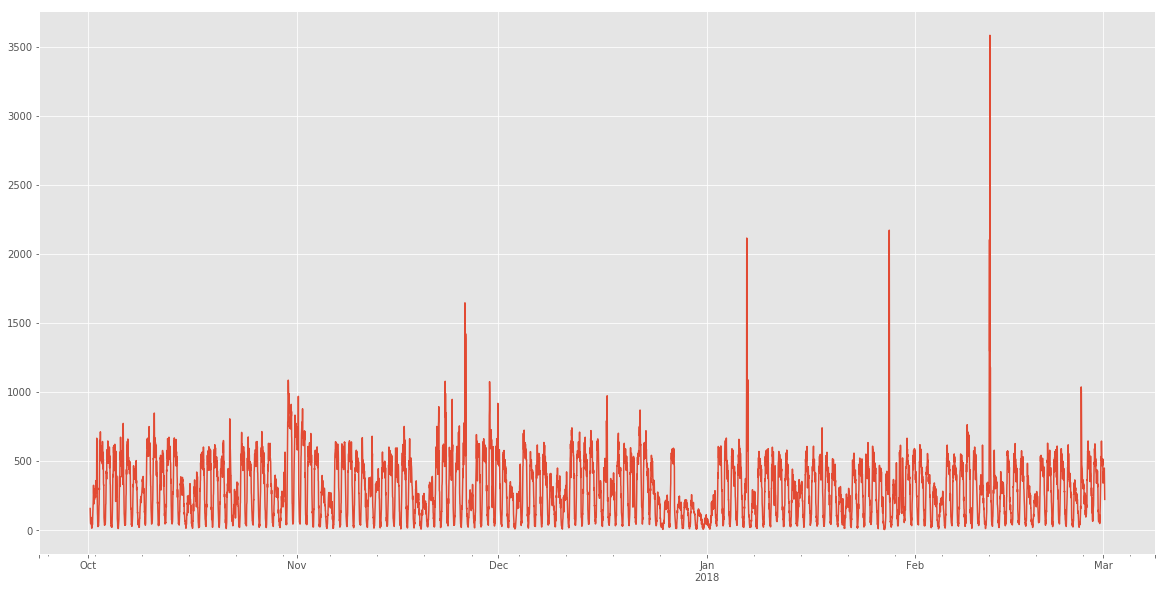

In [3]:
main_resampled = main_ts.resample('30Min').sum()
main_resampled.plot();

In [4]:
stl = decompose(main_resampled, period=336)

In [5]:
residnormal = stl.resid
type(main_resampled)

pandas.core.series.Series

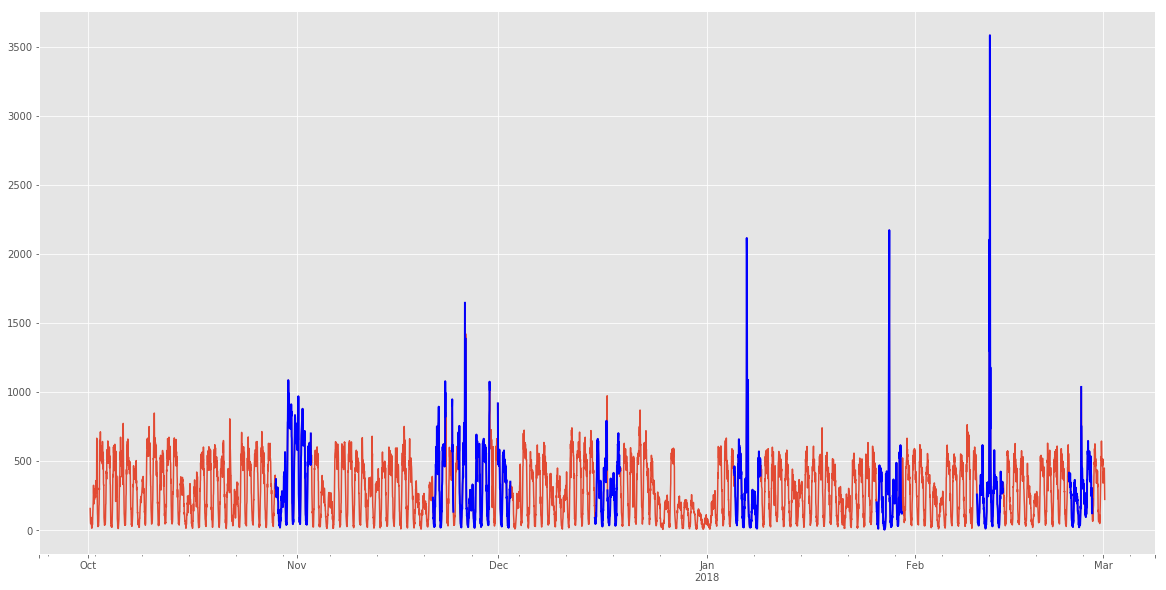

In [6]:
from collections import OrderedDict

def epoch2ts(val):
    return pd.to_datetime(val, unit='s')

lumi_ts = {k.timestamp(): v for k, v in main_resampled.to_dict(into=OrderedDict).items()}

detector = anomaly_detector.AnomalyDetector(lumi_ts, score_threshold=5)
anomalies = detector.get_anomalies()
main_resampled.plot()
for a in anomalies:
    #print(epoch2ts(a.exact_timestamp))
    start, end = a.get_time_window()
    pd.Series({epoch2ts(k): lumi_ts[k] for k in lumi_ts.keys() if k >= start and k <= end}).plot(color='blue',linewidth=2.0)

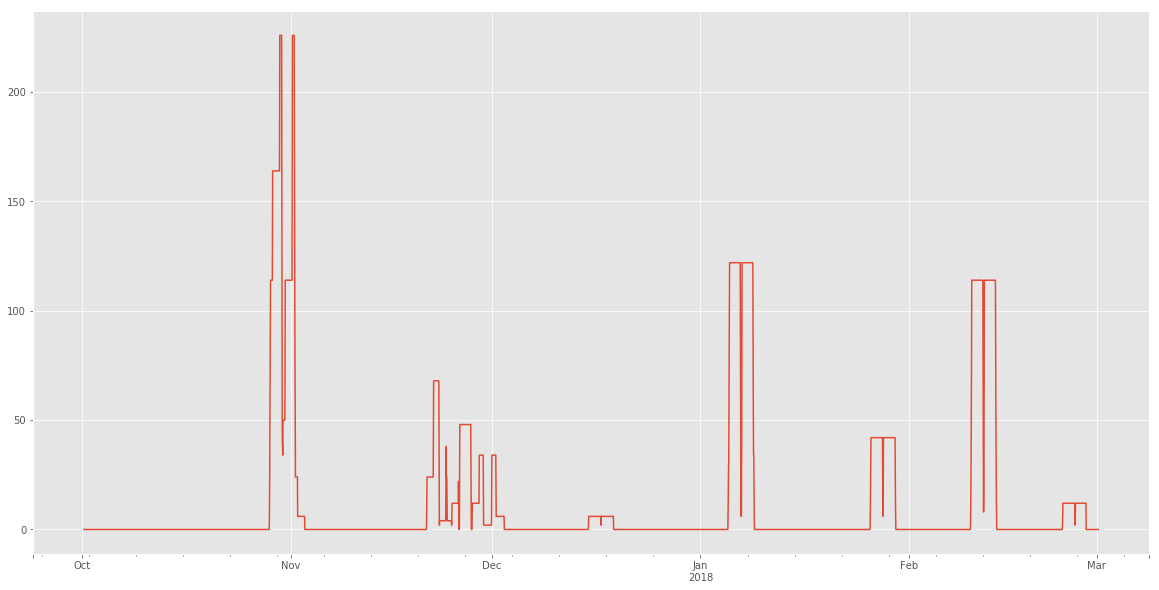

In [7]:
listscores = detector.anom_scores.items()
idx = []
val = []
for s in listscores:
    idx.append(epoch2ts(s[0]))
    val.append(s[1])
    
pdscores = pd.Series(val, index=idx)
pdscores.plot()

In [8]:
for a in anomalies:
    print(epoch2ts(a.start_timestamp))
    print(epoch2ts(a.end_timestamp))
    print(epoch2ts(a.exact_timestamp))
    print(a.anomaly_score)
    print('\n')

2017-10-28 20:30:00
2017-11-03 02:00:00
2017-10-30 18:00:00
226.0


2017-11-21 06:00:00
2017-11-23 03:00:00
2017-11-23 03:00:00
68.0


2017-11-24 02:30:00
2017-11-24 07:00:00
2017-11-24 03:30:00
38.0


2017-11-25 00:00:00
2017-11-26 00:30:00
2017-11-25 23:30:00
22.0


2017-11-26 03:30:00
2017-11-27 21:00:00
2017-11-27 21:00:00
48.0


2017-11-28 00:30:00
2017-11-29 17:00:00
2017-11-29 17:00:00
34.0


2017-11-30 22:00:00
2017-12-02 18:30:00
2017-11-30 23:00:00
34.0


2017-12-15 08:30:00
2017-12-17 04:00:00
2017-12-15 08:30:00
6.0


2017-12-17 05:30:00
2017-12-19 01:00:00
2017-12-17 05:30:00
6.0


2018-01-05 02:30:00
2018-01-09 00:00:00
2018-01-07 04:30:00
122.0


2018-01-26 06:30:00
2018-01-30 01:00:00
2018-01-28 03:30:00
42.0


2018-02-10 05:00:00
2018-02-14 01:30:00
2018-02-12 02:30:00
114.0


2018-02-23 21:30:00
2018-02-25 17:30:00
2018-02-23 22:00:00
12.0


2018-02-25 18:30:00
2018-02-27 09:00:00
2018-02-25 19:00:00
12.0




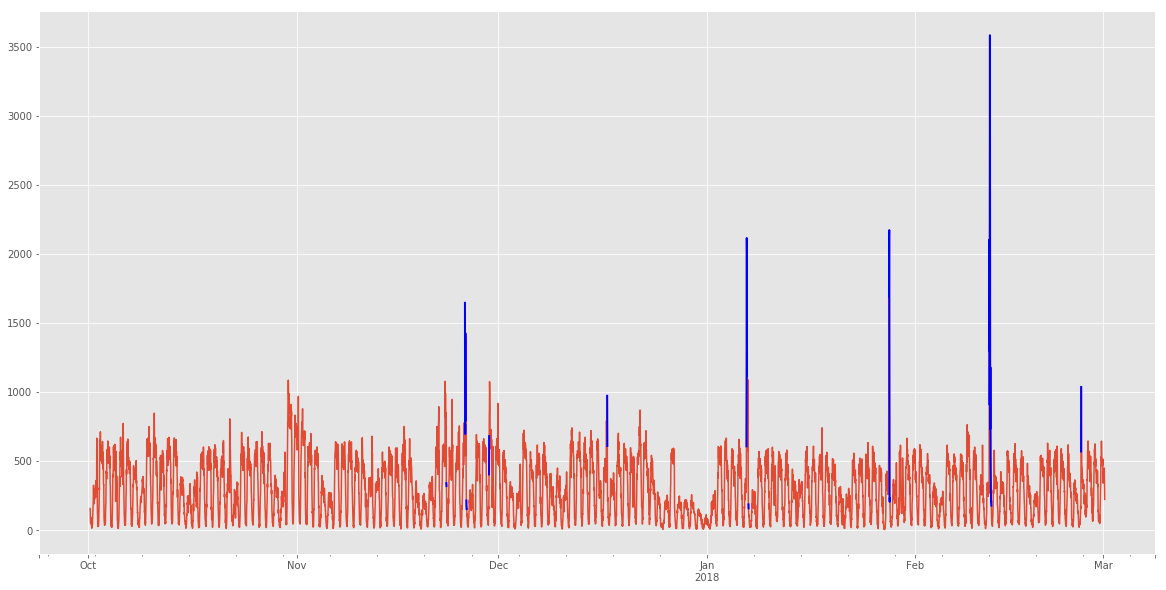

In [9]:
detector = anomaly_detector.AnomalyDetector(lumi_ts, algorithm_name='derivative_detector')
anomalies = detector.get_anomalies()
main_resampled.plot()
for a in anomalies:
    #print(epoch2ts(a.exact_timestamp))
    start, end = a.get_time_window()
    pd.Series({epoch2ts(k): lumi_ts[k] for k in lumi_ts.keys() if k >= start and k <= end}).plot(color='blue',linewidth=2.0)

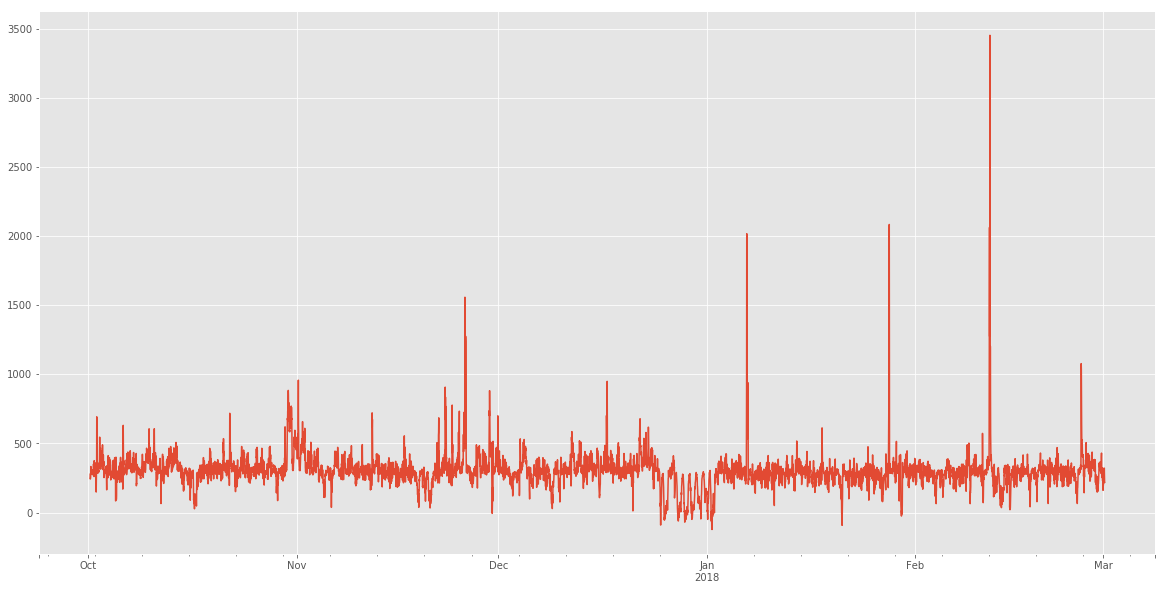

In [10]:
main_sin_periodo = main_resampled.sub(stl.seasonal)
main_sin_periodo.plot()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=336,ignore_na=False,adjust=True,min_periods=0).mean()
  


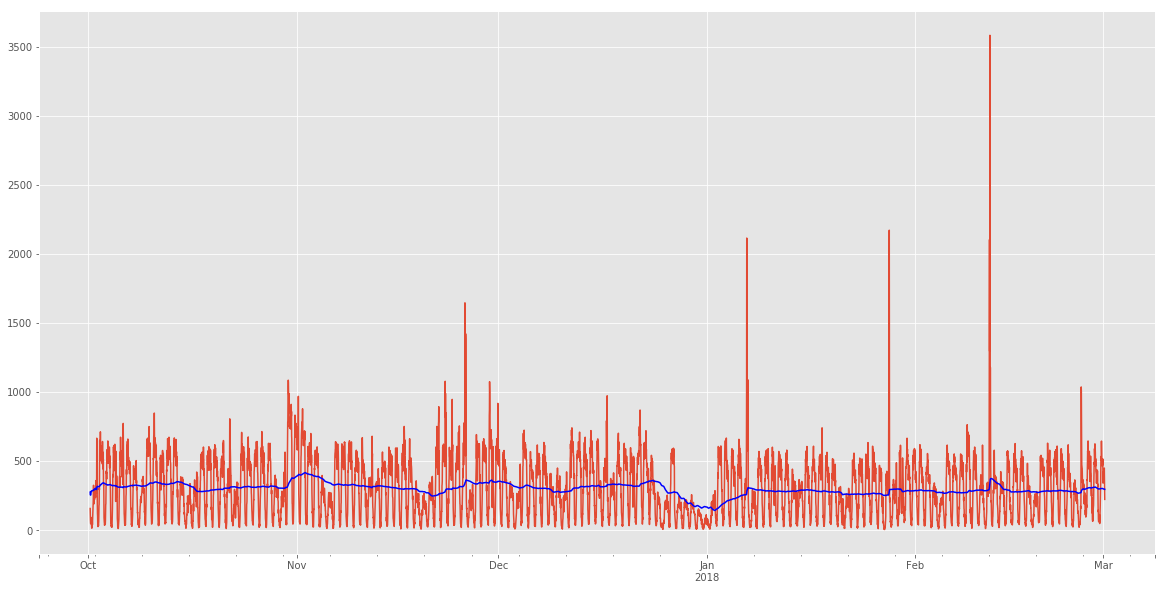

In [11]:
#probando exp moving average
main_ema = pd.ewma(main_sin_periodo, span=336)
main_resampled.plot()
main_ema.plot(color='blue');

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=336).median()
  


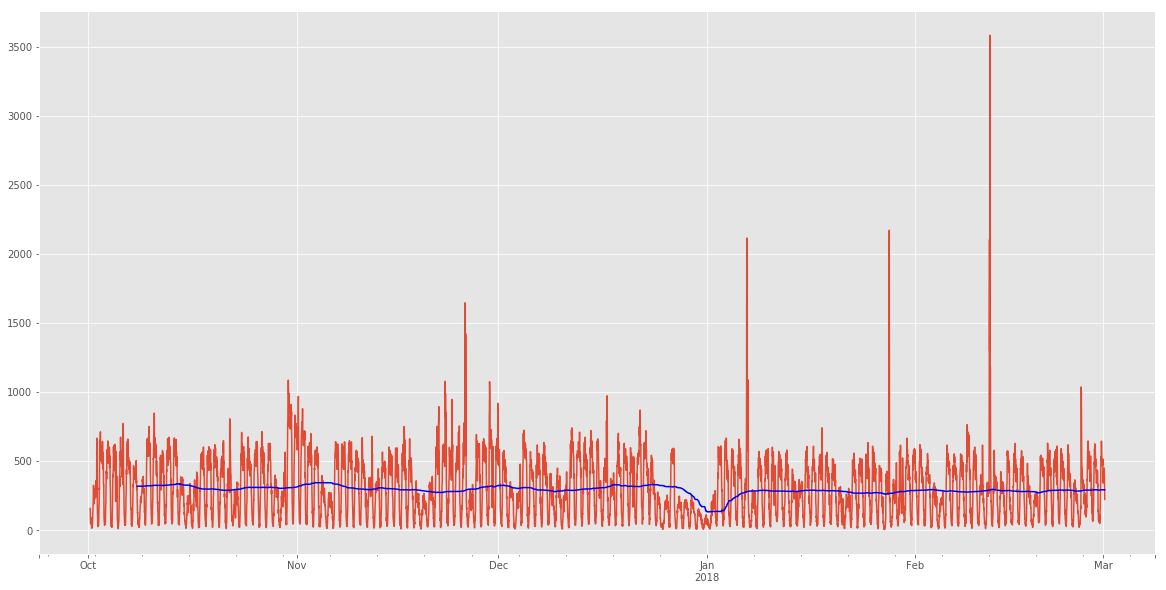

In [12]:
#moving median
median = pd.rolling_median(main_sin_periodo, window=336)
main_resampled.plot()
median.plot(color='blue');

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=336).mean()
  


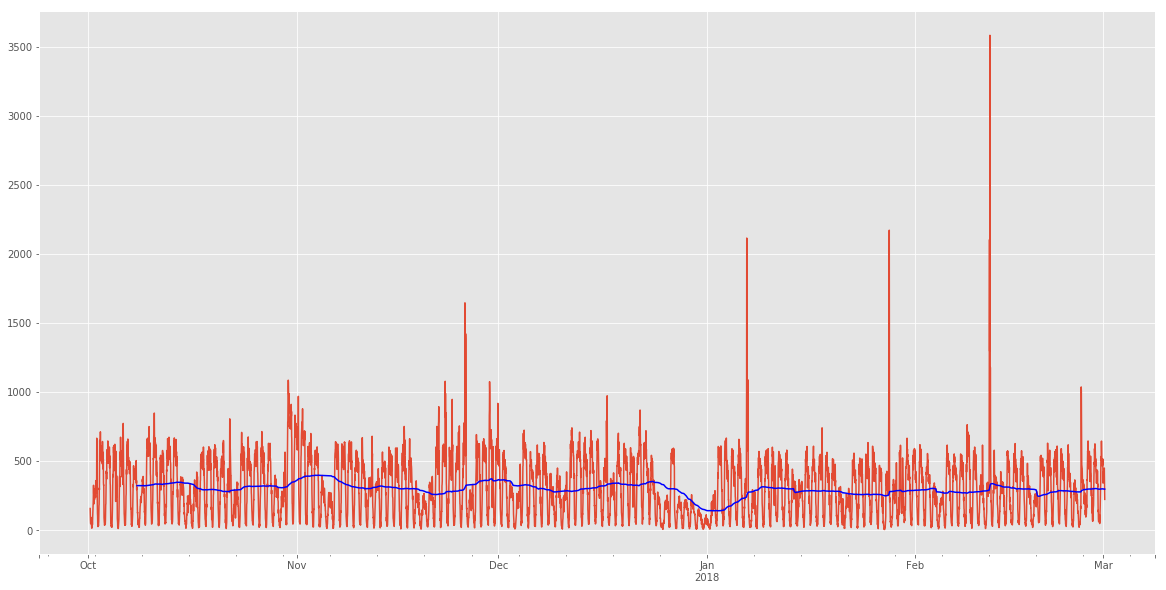

In [13]:
#moving average
mean = pd.rolling_mean(main_sin_periodo, window=336)
main_resampled.plot()
mean.plot(color='blue');

In [14]:
print(main_resampled.median())
ts_median = pd.Series(main_resampled.median(), index=main_resampled.index)

277.0


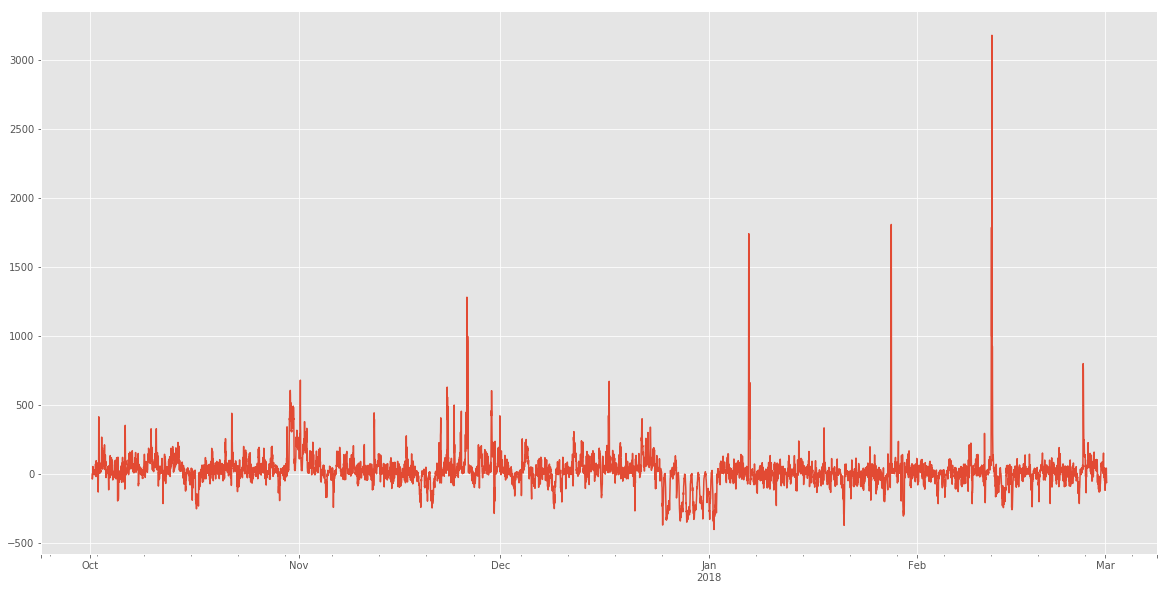

In [15]:
true_resid = main_resampled.sub(stl.seasonal).sub(ts_median)
true_resid.plot()

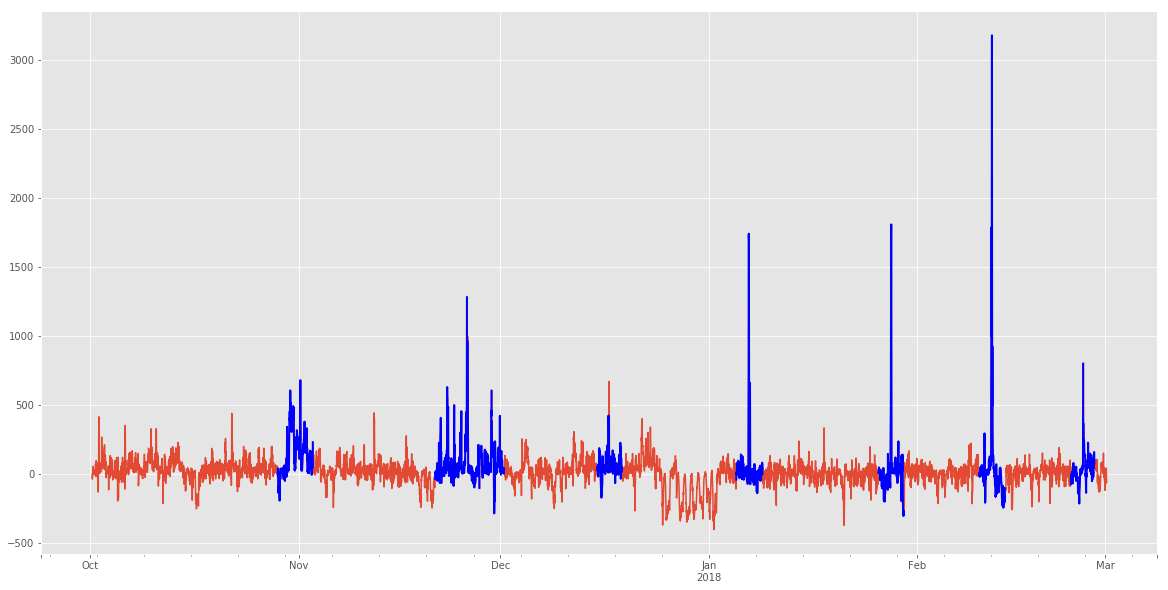

In [16]:
lumi_ts = {k.timestamp(): v for k, v in true_resid.to_dict(into=OrderedDict).items()}

detector = anomaly_detector.AnomalyDetector(lumi_ts, score_threshold=5)
anomalies = detector.get_anomalies()
true_resid.plot()
for a in anomalies:
    #print(epoch2ts(a.exact_timestamp))
    start, end = a.get_time_window()
    pd.Series({epoch2ts(k): lumi_ts[k] for k in lumi_ts.keys() if k >= start and k <= end}).plot(color='blue',linewidth=2.0)